In [71]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from wordcloud import WordCloud, STOPWORDS
from ast import literal_eval
from matplotlib_venn import venn2
import nltk
nltk.download('all')

sns.set_palette(sns.color_palette("deep"))

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/arinaruck/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/

In [4]:
data_folder = Path('data/')
pickle_folder = data_folder / 'pickles'
imdb_folder = data_folder / 'IMDB'

## Overview of terms related to characters of different genders

### Preparing the relevant data

Let's look at the verbs describing characters in movies. To analyse the dynamics in portraying different characters we need the biometrics info as well as the year of movie release.
For that we need to merge the characters to corresponding actors and gather all relevant data.

In [5]:
with open(pickle_folder / 'character_verbs_2.p', 'rb') as f:
    characters_desc = pickle.load(f)

with open(pickle_folder / 'characters.p', 'rb') as f:
    characters = pickle.load(f)

In [6]:
characters_desc

movie           character  \
wiki_id_character_name                                      
10000053_La Bete             10000053             La Bete   
10002175_Melora Kendall      10002175      Melora Kendall   
10002175_Bobbie Chester      10002175      Bobbie Chester   
10004330_Pigeon Lane         10004330         Pigeon Lane   
10004330_Lt. Col. Gilfillan  10004330  Lt. Col. Gilfillan   
...                               ...                 ...   
99984_Miguel                    99984              Miguel   
99984_Charlie                   99984             Charlie   
99984_Ricky                     99984               Ricky   
99984_Senora Mia                99984          Senora Mia   
99984_Xavier                    99984              Xavier   

                                              agent_word  \
wiki_id_character_name                                     
10000053_La Bete                                     NaN   
10002175_Melora Kendall                              NaN   
10002175_Bobbie Chester                              NaN   
10004330_Pigeon Lane                     [shoots, kills]   
10004330_Lt. Col. Gilfillan  [warns, recounts, receives]   
...                                                  ...   
99984_Miguel                                         NaN   
99984_Charlie                                        NaN   
99984_Ricky                                          NaN   
99984_Senora Mia                                     NaN   
99984_Xavier                                         NaN   

                                          agent_lemma patient_word  \
wiki_id_character_name                                               
10000053_La Bete                                  NaN          NaN   
10002175_Melora Kendall                           NaN          NaN   
10002175_Bobbie Chester                           NaN          NaN   
10004330_Pigeon Lane                    [shoot, kill]     [timers]   
10004330_Lt. Col. Gilfillan  [warn, recount, receive]          NaN   
...                                               ...          ...   
99984_Miguel                                      NaN          NaN   
99984_Charlie                                     NaN          NaN   
99984_Ricky                                       NaN          NaN   
99984_Senora Mia                                  NaN          NaN   
99984_Xavier                                      NaN          NaN   

                            patient_lemma attribute_word attribute_lemma  
wiki_id_character_name                                                    
10000053_La Bete                      NaN            NaN             NaN  
10002175_Melora Kendall               NaN            NaN             NaN  
10002175_Bobbie Chester               NaN            NaN             NaN  
10004330_Pigeon Lane              [timer]            NaN             NaN  
10004330_Lt. Col. Gilfillan           NaN            NaN             NaN  
...                                   ...            ...             ...  
99984_Miguel                          NaN            NaN             NaN  
99984_Charlie                         NaN            NaN             NaN  
99984_Ricky                           NaN            NaN             NaN  
99984_Senora Mia                      NaN            NaN             NaN  
99984_Xavier                          NaN            NaN             NaN  

[139873 rows x 8 columns]

In [7]:
characters_desc['movie'] = pd.to_numeric(characters_desc['movie'])
characters_non_empty_desc =  characters_desc[~characters_desc.agent_word.isna() | ~characters_desc.patient_word.isna()]
print(f'Kept {len(characters_non_empty_desc) / len( characters_desc) * 100:.2f}% of the characters with agent or patient words')
display(characters_non_empty_desc.head())

assert (characters_non_empty_desc.patient_word.isna() == characters_non_empty_desc.patient_lemma.isna()).all(), \
    'not all patient verbs have corresponding lemmas'
assert (characters_non_empty_desc.agent_word.isna() == characters_non_empty_desc.agent_lemma.isna()).all(), \
    'not all patient verbs have corresponding lemmas'

Kept 45.97% of the characters with agent or patient words


movie                   character  \
wiki_id_character_name                                                      
10004330_Pigeon Lane                 10004330                 Pigeon Lane   
10004330_Lt. Col. Gilfillan          10004330          Lt. Col. Gilfillan   
10004330_Coffman                     10004330                     Coffman   
10004664_Krishnakant Mathur (Kittu)  10004664  Krishnakant Mathur (Kittu)   
10004664_Mr. Mathur                  10004664                  Mr. Mathur   

                                                      agent_word  \
wiki_id_character_name                                             
10004330_Pigeon Lane                             [shoots, kills]   
10004330_Lt. Col. Gilfillan          [warns, recounts, receives]   
10004330_Coffman                                             NaN   
10004664_Krishnakant Mathur (Kittu)                          NaN   
10004664_Mr. Mathur                                          NaN   

                                                  agent_lemma  \
wiki_id_character_name                                          
10004330_Pigeon Lane                            [shoot, kill]   
10004330_Lt. Col. Gilfillan          [warn, recount, receive]   
10004330_Coffman                                          NaN   
10004664_Krishnakant Mathur (Kittu)                       NaN   
10004664_Mr. Mathur                                       NaN   

                                         patient_word  patient_lemma  \
wiki_id_character_name                                                 
10004330_Pigeon Lane                         [timers]        [timer]   
10004330_Lt. Col. Gilfillan                       NaN            NaN   
10004330_Coffman                     [killed, timers]  [kill, timer]   
10004664_Krishnakant Mathur (Kittu)           [taken]         [take]   
10004664_Mr. Mathur                           [taken]         [take]   

                                    attribute_word attribute_lemma  
wiki_id_character_name                                              
10004330_Pigeon Lane                           NaN             NaN  
10004330_Lt. Col. Gilfillan                    NaN             NaN  
10004330_Coffman                               NaN             NaN  
10004664_Krishnakant Mathur (Kittu)            NaN             NaN  
10004664_Mr. Mathur                            NaN             NaN

In [8]:
def convert_to_list(str_list):
    converted_list = str_list[1:-1].split(',')
    return converted_list

Let's approximate the age of the actors by substracting their date of birth from the movie release date

In [9]:
characters_keep_columns = ['movie_wiki_id', 'character_name', 'combined_gender', 
                           'combined_ethnicity', 'combined_release_year', 'combined_birth']
characters_with_description = characters_non_empty_desc.merge(characters[characters_keep_columns], 
                                                              right_on=['movie_wiki_id', 'character_name'], 
                                                              left_on=['movie', 'character'],
                                                              how='left')
                                                              
characters_with_description['patient_lemma'].fillna('', inplace=True)
characters_with_description['agent_lemma'].fillna('', inplace=True)                                                   
characters_with_description['age'] = characters_with_description['combined_release_year'] - characters_with_description['combined_birth']
characters_with_description['decade'] = characters_with_description['combined_release_year'].apply(lambda x: x // 10 * 10)
characters_with_description

movie                   character  \
0      10004330                 Pigeon Lane   
1      10004330          Lt. Col. Gilfillan   
2      10004330                     Coffman   
3      10004664  Krishnakant Mathur (Kittu)   
4      10004664                  Mr. Mathur   
...         ...                         ...   
65533    999394             Captain Bellamy   
65534    999394             Hector Barbossa   
65535     99948                     Cupcake   
65536   9998295                Sam Spade Jr   
65537   9998295                 Wilmer Cook   

                                 agent_word                     agent_lemma  \
0                           [shoots, kills]                   [shoot, kill]   
1               [warns, recounts, receives]        [warn, recount, receive]   
2                                       NaN                                   
3                                       NaN                                   
4                                       NaN                                   
...                                     ...                             ...   
65533                                   NaN                                   
65534                                   NaN                                   
65535                                   NaN                                   
65536  [dies, delivers, dealing, discovers]  [die, deliver, deal, discover]   
65537                                   NaN                                   

           patient_word  patient_lemma attribute_word attribute_lemma  \
0              [timers]        [timer]            NaN             NaN   
1                   NaN                           NaN             NaN   
2      [killed, timers]  [kill, timer]            NaN             NaN   
3               [taken]         [take]            NaN             NaN   
4               [taken]         [take]            NaN             NaN   
...                 ...            ...            ...             ...   
65533         [require]      [require]            NaN             NaN   
65534             [see]          [see]            NaN             NaN   
65535          [seeing]          [see]            NaN             NaN   
65536           [given]         [give]            NaN             NaN   
65537            [gets]          [get]            NaN             NaN   

       movie_wiki_id              character_name combined_gender  \
0           10004330                 Pigeon Lane            male   
1           10004330          Lt. Col. Gilfillan            male   
2           10004330                     Coffman            male   
3           10004664  Krishnakant Mathur (Kittu)            male   
4           10004664                  Mr. Mathur            male   
...              ...                         ...             ...   
65533         999394             Captain Bellamy            male   
65534         999394             Hector Barbossa            male   
65535          99948                     Cupcake            male   
65536        9998295                Sam Spade Jr            male   
65537        9998295                 Wilmer Cook            male   

        combined_ethnicity  combined_release_year  combined_birth   age  \
0      Ukrainian Americans                 1950.0          1919.0  31.0   
1                      NaN                 1950.0          1917.0  33.0   
2                      NaN                 1950.0          1930.0  20.0   
3                  Indians                 1999.0          1978.0  21.0   
4                  Indians                 1999.0          1952.0  47.0   
...                    ...                    ...             ...   ...   
65533                  NaN                 2006.0          1950.0  56.0   
65534                  NaN                 2006.0          1951.0  55.0   
65535                  NaN                 1994.0          1952.0  42.0   
65536                  NaN                 1975.0   

### Descriptive statistics

Let's look at the number of datapoints we have for each decade:

Text(0.5, 1.0, 'Gender-wise caracter count in the dataset')

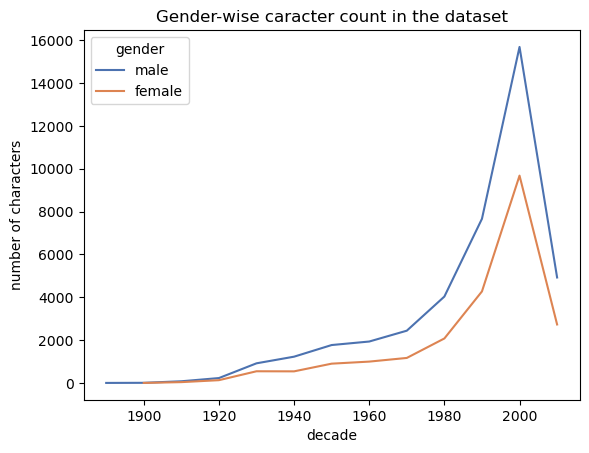

In [10]:
decade_counts = characters_with_description.groupby(by=['decade', 'combined_gender']).count()
decade_counts = decade_counts.reset_index()
decade_counts = decade_counts[['decade', 'combined_gender', 'character']]
# we consider only 2 genders for the overview since only they are present in the most of the decades
# we will consider all genders in the more in depth analysis
decade_counts = decade_counts[decade_counts['combined_gender'].isin(['male', 'female'])]
ax = sns.lineplot(decade_counts, x='decade', y='character', hue='combined_gender')
ax.get_legend().set_title('gender')
ax.set_ylabel('number of characters')
ax.set_title('Gender-wise caracter count in the dataset')

We can see that the amount of data before 1920 is not sufficient for the analysis with tens (or even less) characters per gender group.

The significant drop in 2010 can be explained by the fact that not all movies for the decade were created at the time of data collection.

In [11]:
CUTOFF_DECADE = 1920

characters_with_description = characters_with_description[characters_with_description['decade'] >= CUTOFF_DECADE]

In [12]:
def aggregate_into_set(lemma_lists):
    lemma_set = set()
    for lemma_list in lemma_lists:
        for lemma in lemma_list:
            lemma_set.add(lemma)
    return lemma_set

Next, we would like to see the number of unique terms used to describe characters of each genre.

In [13]:
def plot_decade_lemmas(df, lemma_type):
    decade_lemmas = df[['decade', 'combined_gender', f'{lemma_type}_lemma', 'character']].groupby(by=['decade', 'combined_gender']).agg(
        {f'{lemma_type}_lemma': aggregate_into_set, 'character': 'count'})
    decade_lemmas = decade_lemmas.reset_index()
    decade_lemmas['n_unique'] = decade_lemmas[f'{lemma_type}_lemma'].str.len()
    decade_lemmas['unique_per_character'] = decade_lemmas['n_unique'] / decade_lemmas['character']
    display(decade_lemmas.head())

    # we consider only 2 genders for the overview since only they are present in the most of the decades
    # we will consider all genders in the more in depth analysis
    decade_lemmas = decade_lemmas[decade_lemmas['combined_gender'].isin(['male', 'female'])]
    fig = plt.figure(figsize=(17, 8))
    ax1 = sns.lineplot(decade_lemmas, x='decade', y='n_unique', hue='combined_gender')
    ax2 = sns.lineplot(decade_lemmas, x='decade', y='unique_per_character', hue='combined_gender', linestyle='--', ax=ax1.axes.twinx())
    ax1.set_ylabel(f'number of unique {lemma_type} terms')
    ax2.set_ylabel(f'number of unique {lemma_type} terms per character')
    plt.title(f'Gender-wise {lemma_type} descriptions in the dataset')

decade combined_gender                                        agent_lemma  \
0  1920.0          female  {run, exercise, ascend, go, die, await, togeth...   
1  1920.0            male  {sneer, use, share, buy, furious, open, welcom...   
2  1930.0          female  {use, shed, socialite\/heiress, dancer, hit, p...   
3  1930.0            male  {press, shrink, use, shed, hit, notify, hop, m...   
4  1940.0          female  {use, hit, share, notify, silent, listen, buy,...   

   character  n_unique  unique_per_character  
0        129       248              1.922481  
1        228       316              1.385965  
2        545       583              1.069725  
3        916       776              0.847162  
4        541       591              1.092421

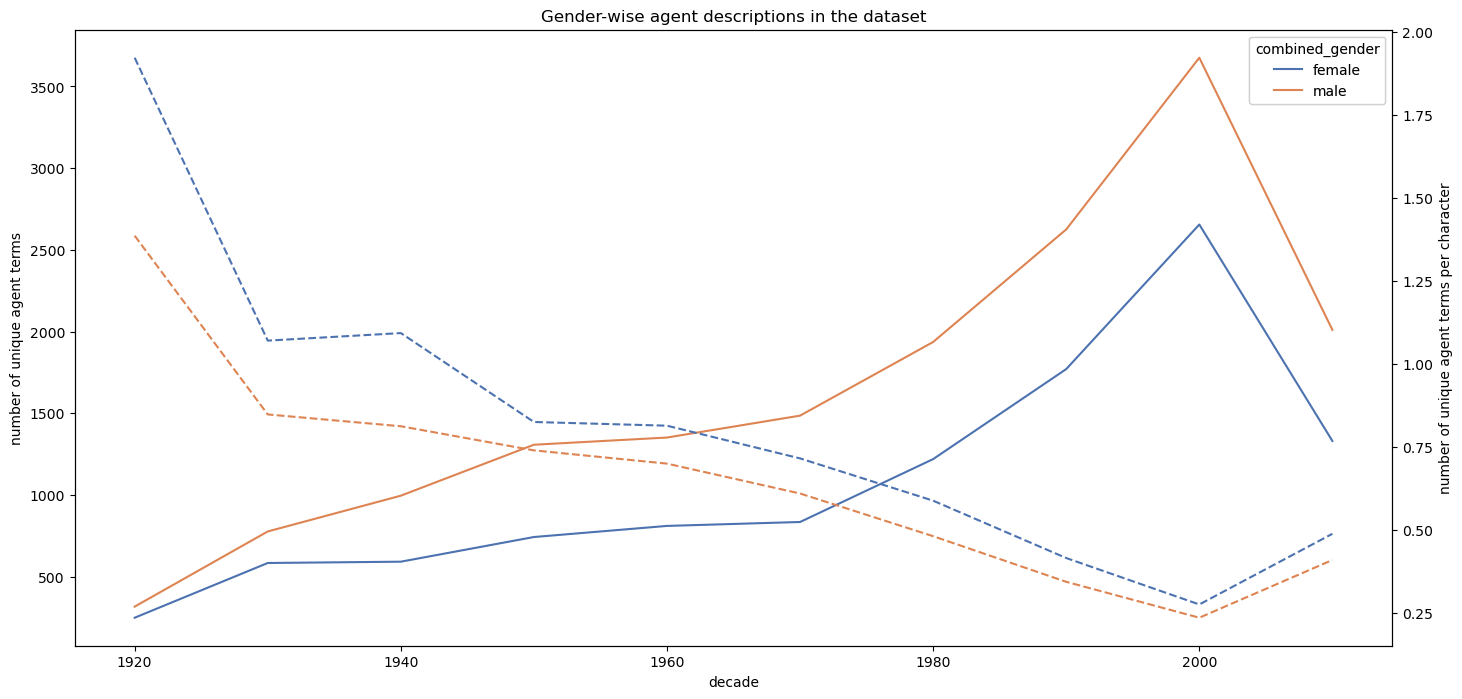

In [14]:
plot_decade_lemmas(characters_with_description, 'agent')

decade combined_gender                                      patient_lemma  \
0  1920.0          female  {run, use, cry, go, share, harass, recognize, ...   
1  1920.0            male  {run, cry, towering, go, assign, recognizable,...   
2  1930.0          female  {press, devastate, use, notify, from, buy, wel...   
3  1930.0            male  {press, devastate, use, hit, share, listen, bu...   
4  1940.0          female  {overjoy, devastate, use, hit, share, listen, ...   

   character  n_unique  unique_per_character  
0        129       182              1.410853  
1        228       240              1.052632  
2        545       482              0.884404  
3        916       677              0.739083  
4        541       481              0.889094

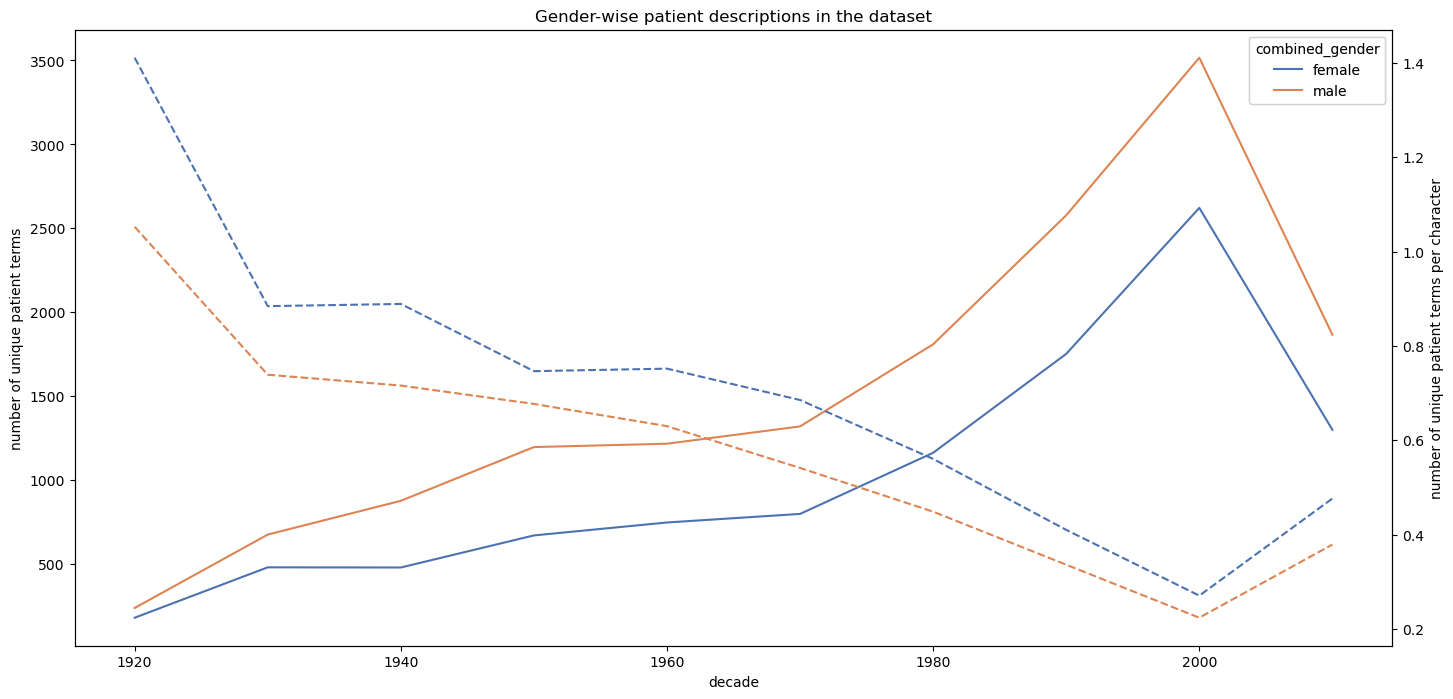

In [15]:
plot_decade_lemmas(characters_with_description, 'patient')

We see that in both cases the number of gender specific-terms is lower for female character than for the male ones. 
Nethertheless, the number of unique terms per character is consistently higher for females than for males.
This can mean that even though there are less female characters they are more thought-through.

### Initial qualitive analysis

Let's start by looking at agent and patient words in general:

In [16]:
from collections import Counter

def join_lemmas(column):
    return (column.apply(lambda x:' '.join(x)) + ' ').sum()

def lemma_frqs(column):
    all_verbs = sum(column[column != ''], [])
    freqs = Counter(all_verbs)
    return freqs

In [17]:
patient_freqs = lemma_frqs(characters_with_description['patient_lemma'])
agent_freqs = lemma_frqs(characters_with_description['patient_lemma'])

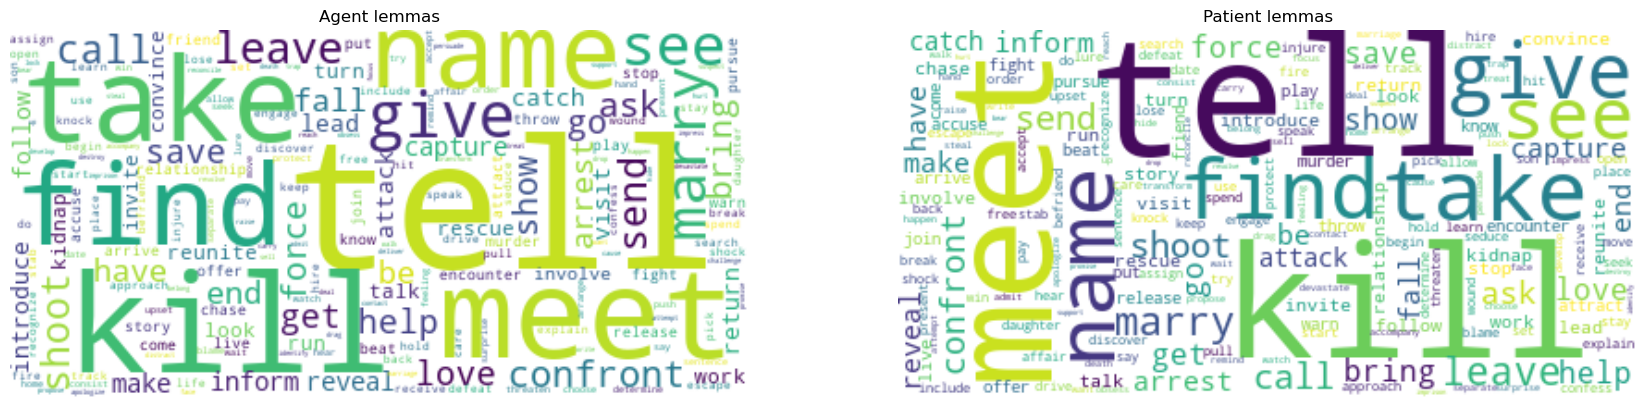

In [18]:
wordcloud_agent = WordCloud(background_color="white", margin=1).generate_from_frequencies(agent_freqs)
wordcloud_patient = WordCloud(background_color="white", margin=1).generate_from_frequencies(patient_freqs)

fig, axes = plt.subplots(1, 2, figsize=(21, 9))

axes[0].imshow(wordcloud_agent, interpolation='bilinear')
axes[0].set_title('Agent lemmas')
axes[0].axis("off")
axes[1].imshow(wordcloud_patient, interpolation='bilinear')
axes[1].set_title('Patient lemmas')
axes[1].axis("off")
plt.show()

We can see, that generally the agent and patient terms have a similar distribution.

Though both of them can be informative, we would like to focus on agent terms for our initial analysis (what the character is/does). 

To highlight the difference, let's look at only gender-specific active verbs, meaning the ones that are present for only one gender.

To see if the term distribution (of which we get a rough understanding with word clouds) changes over time, we can look at a subsample (equally sized) of decades.

In [19]:
def get_unique_verbs_and_freqs(column):
    freqs = lemma_frqs(column)
    uniq_verbs = set(freqs.keys())
    return freqs, uniq_verbs

def get_subset_freqs(default_freqs, subset):
    subset_freqs = {k: default_freqs[k] for k in subset}
    return subset_freqs

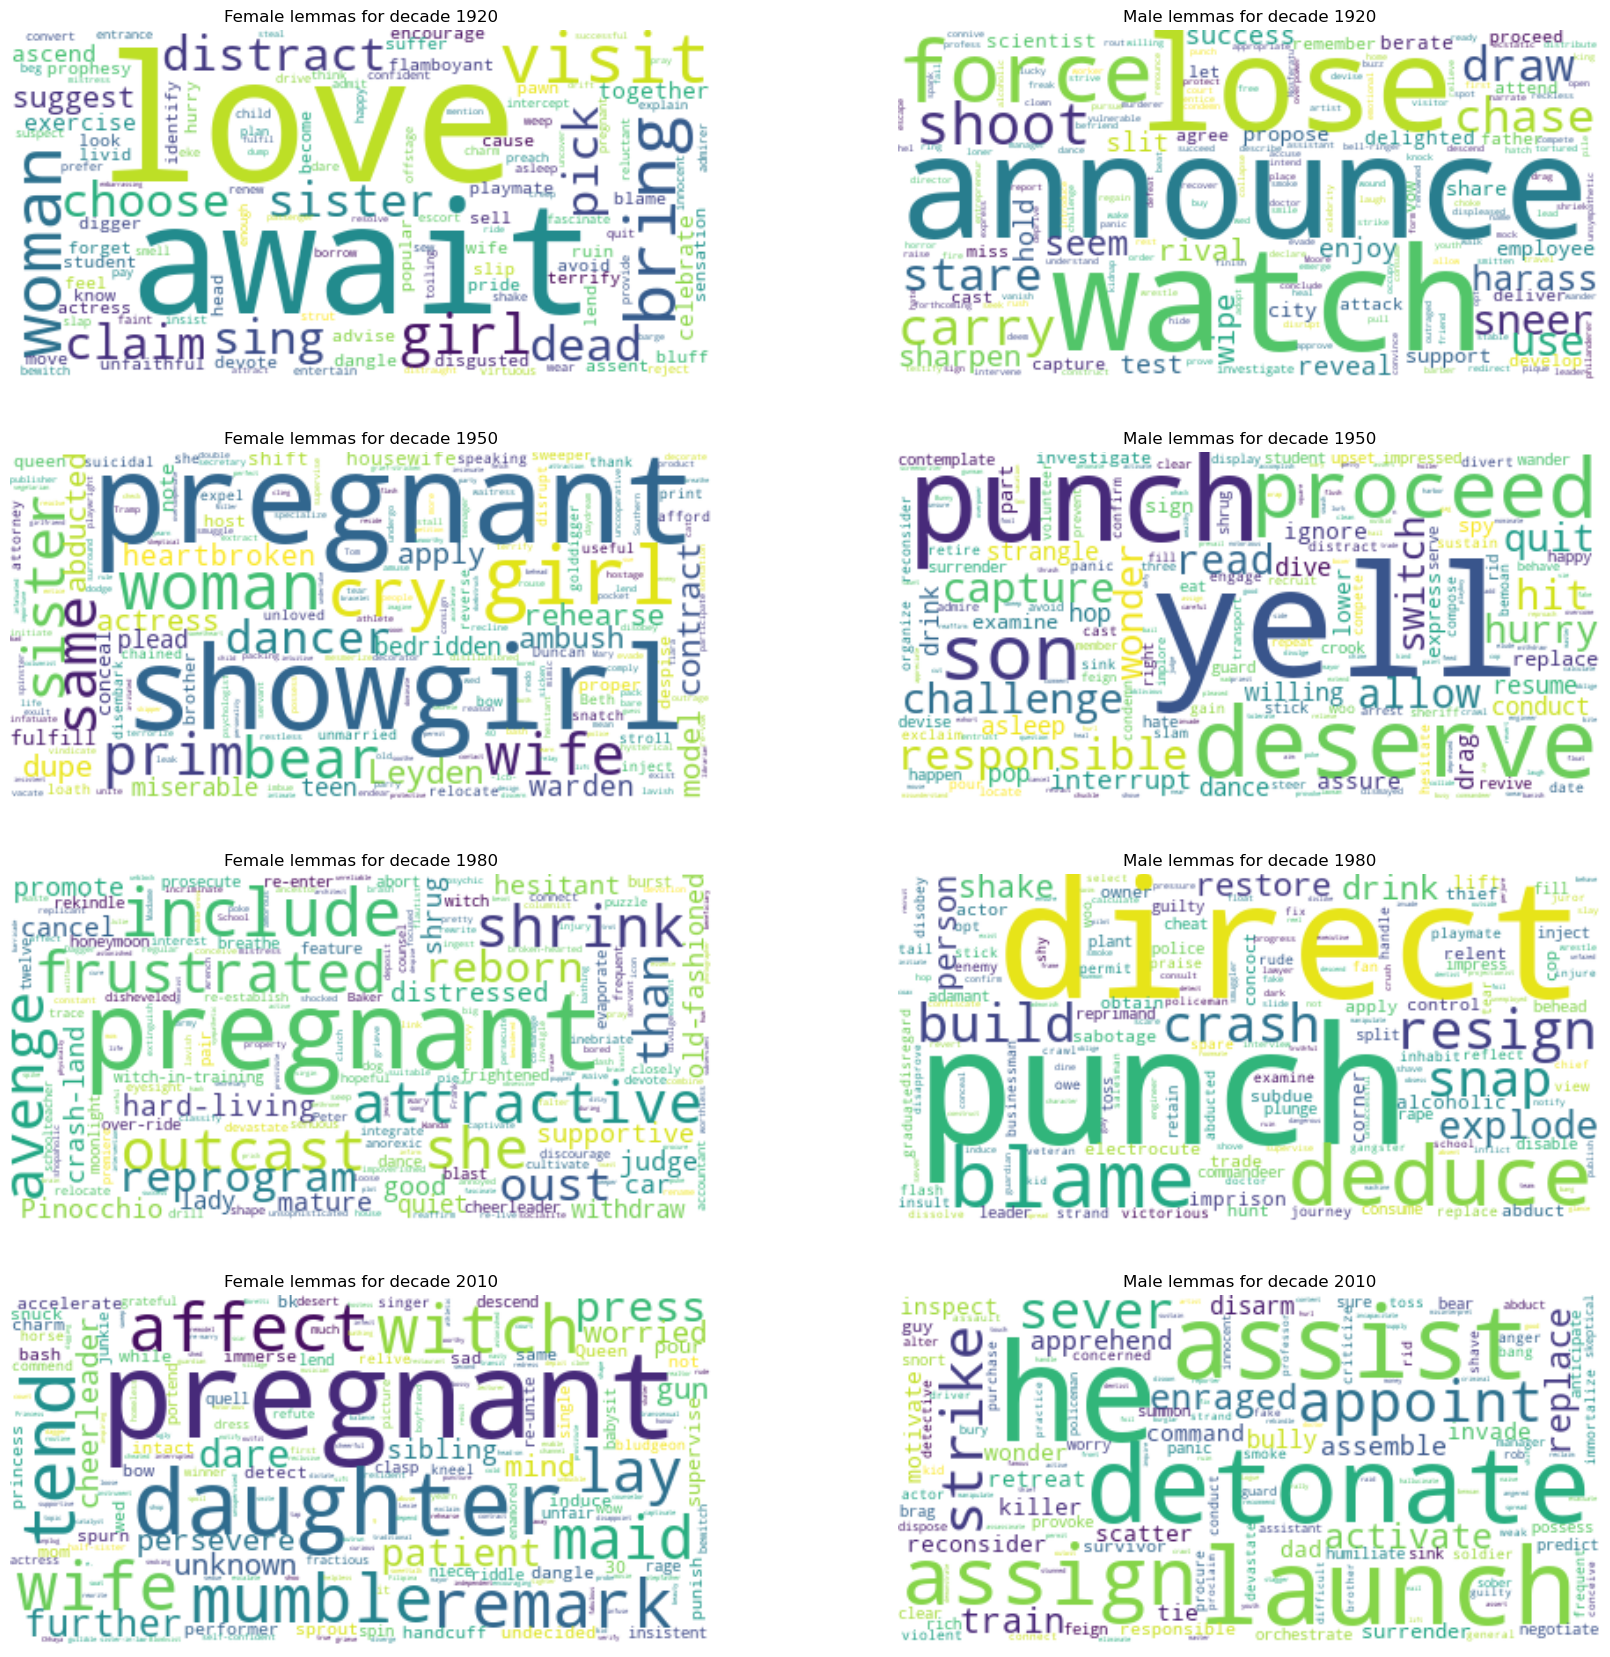

In [20]:
decades = [1920, 1950, 1980, 2010]

fig, axes = plt.subplots(len(decades), 2, figsize=(21, 21))

female_specific_verbs_nums = []
male_specific_verbs_nums = []

for i, decade in enumerate(decades):
    decade_descriptions = characters_with_description[characters_with_description['decade'] == decade]

    female_agent_freqs, female_agent_verbs = get_unique_verbs_and_freqs(decade_descriptions[
            decade_descriptions['combined_gender'] == 'female']['agent_lemma'])
    male_agent_freqs, male_agent_verbs = get_unique_verbs_and_freqs(decade_descriptions[
        decade_descriptions['combined_gender'] == 'male']['agent_lemma'])

    female_only_agent_verbs = female_agent_verbs - male_agent_verbs
    male_only_agent_verbs = male_agent_verbs - female_agent_verbs

    female_only_agent_freqs = get_subset_freqs(female_agent_freqs, female_only_agent_verbs)
    male_only_agent_freqs = get_subset_freqs(male_agent_freqs, male_only_agent_verbs)

    female_specific_verbs_nums.append(len(female_only_agent_verbs))
    male_specific_verbs_nums.append(len(male_only_agent_verbs))

    wordcloud_female_only = WordCloud(background_color="white", 
                                 margin=1).generate_from_frequencies(female_only_agent_freqs)
    wordcloud_male_only = WordCloud(background_color="white", 
                               margin=1).generate_from_frequencies(male_only_agent_freqs)

    axes[i][0].imshow(wordcloud_female_only, interpolation='bilinear')
    axes[i][0].set_title(f'Female lemmas for decade {decade}')
    axes[i][0].axis("off")
    axes[i][1].imshow(wordcloud_male_only, interpolation='bilinear')
    axes[i][1].set_title(f'Male lemmas for decade {decade}')
    axes[i][1].axis("off")
plt.show()

We can see that the agent words describing women can be roughly subcategorized in 3 groups:
- role / description:  from more general woman, girl, lady, wife to more narrow like maid, showgirl, actress, witch
- "entertaining" characterestics:  attractive, fascinate, performer
- "weak" characterestics: mumble, hesitant, frightened, distressed, miserable, cry

In the same term category for male we can see:
- a lot of "strong" words: punch, yell, capture, challenge, force, shoot
- a lot of actions of a leader: launch, assign, direct, responsible

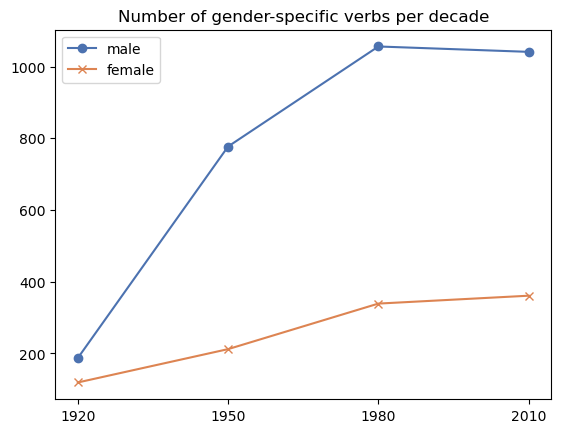

In [21]:
plt.plot(male_specific_verbs_nums, marker='o', label='male')
plt.plot(female_specific_verbs_nums, marker='x', label='female')
plt.xticks(ticks=range(len(decades)), labels=decades)
plt.title('Number of gender-specific verbs per decade')
plt.legend()
plt.show()

We can also see that the number of gender-specific verbs for women is consistently lower than for men. 
Let's look at the shares on the example of one decade:

In [22]:
decade = 2000

millenial_movies = characters_with_description[characters_with_description['decade'] == decade]

In [23]:
_, female_agent = get_unique_verbs_and_freqs(millenial_movies[millenial_movies['combined_gender'] == 'female']['agent_lemma'])
_, male_agent = get_unique_verbs_and_freqs(millenial_movies[millenial_movies['combined_gender'] == 'male']['agent_lemma'])
female_agent_vocabulary = female_agent - male_agent
male_agent_vocabulary = male_agent - female_agent
common_agent_vocabulary = female_agent.intersection(male_agent)

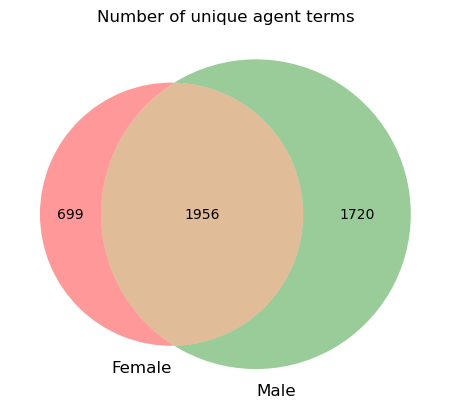

In [24]:
venn2(subsets = (len(female_agent_vocabulary), len(male_agent_vocabulary), len(common_agent_vocabulary)), set_labels = ('Female', 'Male'))
plt.title('Number of unique agent terms')
plt.show()

### Word embeddings

Word clouds give us an understanding of certain trends but they focus on exact formulations and not semantics, to try and capture the similarities of the words and to see if they form some natural groups let's perform clustering over the action verbs.
Let's focus on one decade for the purpose of demonstration and we will do the drill down for other decades later.

In [56]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import metrics
from transformers import BertTokenizer, BertModel
import torch


EMBEDDING_DIM = 100

def load_glove_embeddings(embedding_dim):
    embeddings_index = dict()
    with open(data_folder / f'glove.6B.{embedding_dim}d.txt', 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index

def get_glove_embeddings(vocabulary, loaded_embds=None, embedding_dim=100):
    if not loaded_embds:
        loaded_embds = load_glove_embeddings(embedding_dim=embedding_dim)
    
    size_of_vocabulary = len(vocabulary)
    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))

    skipped = 0
    i = 0
    id2word = {}
    for word in vocabulary:
        embedding_vector = loaded_embds.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            i += 1
            id2word[i] = word
        else:
            skipped += 1
    print(f'Skipped embeddings: {skipped} out of {len(vocabulary)}')
    embedding_matrix = embedding_matrix[:i]
    return embedding_matrix, id2word


def get_bert_embeddings(vocabulary, loaded_model=None, loaded_tokenizer=None):
    if not loaded_model:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained("bert-base-uncased")

    embedding_dim = model.config.hidden_size
    size_of_vocabulary = len(vocabulary)
    embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))
    id2word = {}
    # TODO: rewrite into a batched version
    for i, word in tqdm(enumerate(vocabulary)):
        with torch.no_grad():
            input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0) 
            output = model(input_ids)[0]
            # taking the first and only element of the batch, getting rid of [cls], averaging over the bpes
            embedding_vector = output[0, 1:].mean(dim=0)
            embedding_matrix[i] = embedding_vector.numpy()
            id2word[i] = word
            
    return embedding_matrix, id2word

In [26]:
def cluster_words(vocabulary, embedding_matrix, id2word):

    # using cosine similarity, because it is a meassure of similarity for the embedding training
    db = AgglomerativeClustering(n_clusters=None, distance_threshold=0.7, affinity='cosine', linkage='complete')
    db.fit(embedding_matrix)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(set(labels), flush=True)

    print(f"Estimated number of clusters: {n_clusters}")
    indices = np.arange(len(embedding_matrix))
    k = 5
    for c in range(n_clusters):
        cluster_indices = indices[labels == c]
        if len(cluster_indices) < k:
            print(f'Cluster ({c}) size smaller than {k}, skipping')
            continue
        cluster_example_indices = np.random.choice(cluster_indices, size=k, replace=False)
        cluster_examples = [id2word[idx] for idx in cluster_example_indices]
        print(f'Examples of cluster {c}: {", ".join(cluster_examples)}')
    return labels

def plot_clusters(embedding_matrix, cluster_labels, title):
    X_2d = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(embedding_matrix)
    ax = sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels)
    ax.set_title(title)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

{0, 1, 2, 3, 4, 5}
Estimated number of clusters: 6
Examples of cluster 0: mother-in-law, 11-year-old, double-cross, headmistress, happy-go-lucky
Examples of cluster 1: Afrikaaners, inseminate, fetus, ruffle, immigrate
Examples of cluster 2: loud, dry, Queen, feature, off-balanced
Examples of cluster 3: re-engineer, rafting, idealist, ex-girlfriend, revisit
Examples of cluster 4: appreciative, mispronounce, unbalanced, conduit, complicate
Examples of cluster 5: badmouthe, pathfinder, Doruru, bullmastiff, disinherit


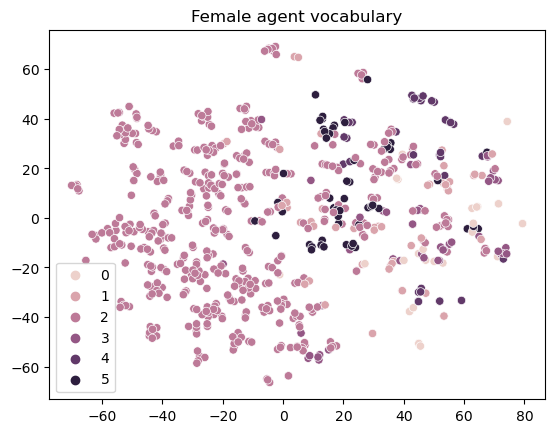

In [27]:
embedding_matrix, id2word = get_bert_embeddings(female_agent_vocabulary)
embedding_matrix.shape

cluster_labels = cluster_words(female_agent_vocabulary, embedding_matrix, id2word)
plot_clusters(embedding_matrix, cluster_labels, 'Female agent vocabulary')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

{0, 1, 2, 3, 4, 5, 6}
Estimated number of clusters: 7
Examples of cluster 0: disapparate, mobilize, ejaculate, misdirect, infrequently
Examples of cluster 1: disgorge, flunk, apolitical, laborer, trounce
Examples of cluster 2: partnership, trauma, black, grapple, program
Examples of cluster 3: out-of-control, daughter-in-law, photographer-cum-editor, hot-wire, right-hand
Examples of cluster 4: Shekhawat, Shibumi, Siddharth, Vijayakumar, Velankani
Examples of cluster 5: gloat, widower, stomp, wallow, goalkeeper
Examples of cluster 6: unhelpful, Krrish, Shroff, gracious, Elspeth


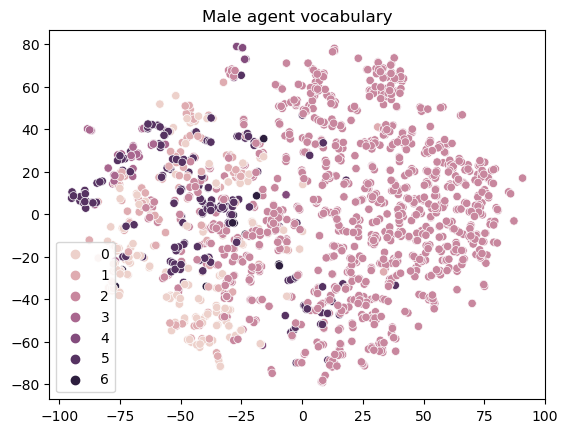

In [28]:
embedding_matrix, id2word = get_bert_embeddings(male_agent_vocabulary)
embedding_matrix.shape

cluster_labels = cluster_words(male_agent_vocabulary, embedding_matrix, id2word)
plot_clusters(embedding_matrix, cluster_labels, 'Male agent vocabulary')

It's important to note, that the dimensionality reduction can not possibly capture all the information of the high dimentional embedding, so the fact that the clusters visualisations are not interpretable makes sense.
Anyway, for now we don't seem to see any meaningful interpretation for the clusters. 
We would continue looking into it and consider different clustering algorithms and parameters to try to achieve the interpretable clustering.
We would also consider soft-clustering as an alternative.

In [61]:
import torch.nn.functional as F

def knn(embedding_matrix, id2word, word2id, word, k=10):
    query = embedding_matrix[word2id[word]]
    x_src = query / np.linalg.norm(query)
    x_tgt = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
    # compute cosine similarity
    scores = x_src @ x_tgt.T
    top_indices = np.argpartition(-scores, k + 1)
    top_words = [id2word[i] for i in top_indices[:k]]
    return top_words


In [57]:
embedding_matrix, id2word = get_glove_embeddings(male_agent_vocabulary)

Loaded 400000 word vectors.
Skipped embeddings: 215 out of 1720


In [65]:
word2id = {word: id for id, word in id2word.items()}
knn(embedding_matrix, id2word, word2id, 'perfect', k=10)

['gawk',
 'puzzling',
 'underachiever',
 'gracious',
 'smart',
 'perfect',
 'rock',
 'also',
 't-shirt',
 'cowboy']

In [93]:
pos_tags = Counter()
for word in male_agent_vocabulary:
    word_tags = nltk.pos_tag([word])
    _, tag = word_tags[0]
    if tag in ['PRP']:#['NNP', 'IN', 'RB', 'CD', 'MD', 'DT', 'PRP']:
        print(word, tag)
    pos_tags[tag] += 1
pos_tags

pos_tags_mapping = {'NN' : 'noun', 'NNS': 'noun', 
                    'VBD': 'verb', 'VB': 'verb', 'MD': 'verb', 'VBG': 'verb', 
                    'RB': 'adverb', 
                    'JJ': 'adjective', 'JJR': 'adjective', 'JJS': 'adjective', }
                    
filter_out = {'IN', 'NNP', 'SD', 'DT', 'PRP'}

we PRP
